### **Importing Dependencies**

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
from geopy.distance import geodesic
import joblib

### **Reading Dataset**

In [2]:
data = pd.read_csv('dataset.csv')
print(f"Initial shape: {data.shape}")

Initial shape: (1296675, 23)


In [3]:
data.head(5)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


### **Date Time Engineering**

In [4]:
data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'])

data['hour'] = data['trans_date_trans_time'].dt.hour
data['day'] = data['trans_date_trans_time'].dt.day
data['month'] = data['trans_date_trans_time'].dt.month

### **Removing Unneeded Columns**

In [5]:
drop_cols = [
    'Unnamed: 0', 'trans_date_trans_time', 'first', 'last', 'street',
    'city', 'state', 'zip', 'dob', 'job', 'trans_num'
]
data.drop(columns=drop_cols, inplace=True)
print(f"After drop: {data.shape}")

After drop: (1296675, 15)


In [24]:
data.head(100)

,cc_num,merchant,category,amt,gender,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,hour,day,month,distance
0,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,36.0788,-81.1781,3495,1325376018,36.011293,-82.048315,0,0,1,1,78.773821
1,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,48.8878,-118.2105,149,1325376044,49.159047,-118.186462,0,0,1,1,30.216618
2,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,M,42.1808,-112.2620,4154,1325376051,43.150704,-112.154481,0,0,1,1,108.102912
3,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,46.2306,-112.1138,1939,1325376076,47.034331,-112.561071,0,0,1,1,95.685115
4,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,M,38.4207,-79.4629,99,1325376186,38.674999,-78.632459,0,0,1,1,77.702395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,4198470814557,fraud_Corwin-Gorczany,misc_net,3.35,F,41.4768,-95.3509,2036,1325380262,41.907592,-95.809232,0,1,1,1,61.197632
96,4423489490781412,fraud_Huels-Nolan,gas_transport,50.61,M,41.6858,-90.3706,1426,1325380451,41.027284,-89.416172,0,1,1,1,108.292039
97,3518234918950662,fraud_Jaskolski-Dibbert,grocery_net,50.74,F,33.6372,-96.6184,46563,1325380451,34.266941,-96.709668,0,1,1,1,70.359444
98,6593250708747804,fraud_DuBuque LLC,grocery_pos,186.73,F,26.7383,-80.2760,26551,1325380495,27.610009,-79.498110,0,1,1,1,123.581739


### **Function calculating distance between transaction loc and merchant loc**

In [6]:
def haversine(lat1, lon1, lat2, lon2):
    return np.array([
        geodesic((a, b), (c, d)).km
        for a, b, c, d in zip(lat1, lon1, lat2, lon2)
    ])

data['distance'] = haversine(
    data['lat'], data['long'], data['merch_lat'], data['merch_long']
)

In [25]:
data.head(500)

,cc_num,merchant,category,amt,gender,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,hour,day,month,distance
0,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,36.0788,-81.1781,3495,1325376018,36.011293,-82.048315,0,0,1,1,78.773821
1,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,48.8878,-118.2105,149,1325376044,49.159047,-118.186462,0,0,1,1,30.216618
2,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,M,42.1808,-112.2620,4154,1325376051,43.150704,-112.154481,0,0,1,1,108.102912
3,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,46.2306,-112.1138,1939,1325376076,47.034331,-112.561071,0,0,1,1,95.685115
4,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,M,38.4207,-79.4629,99,1325376186,38.674999,-78.632459,0,0,1,1,77.702395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,30238755902988,"fraud_Moen, Reinger and Murphy",grocery_pos,102.10,F,30.5920,-97.2893,1766,1325399363,31.070756,-96.972356,0,6,1,1,61.128787
496,6011860238257910,fraud_Strosin-Cruickshank,grocery_pos,168.42,F,36.3850,-98.0727,1078,1325399383,35.594928,-97.620498,0,6,1,1,96.684822
497,3517814635263522,fraud_Deckow-O'Conner,grocery_pos,138.23,M,37.5802,-80.5248,2443,1325399467,38.067150,-79.888697,0,6,1,1,77.830464
498,4585132874641,fraud_Erdman-Kertzmann,gas_transport,69.72,F,39.7417,-93.6289,271,1325399556,39.053407,-93.972916,0,6,1,1,81.960796


In [26]:
data[data['is_fraud'] == 1].head()


,cc_num,merchant,category,amt,gender,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,hour,day,month,distance
2449,4613314721966,fraud_Rutherford-Mertz,grocery_pos,281.06,M,35.9946,-81.7266,885,1325466397,36.430124,-81.179483,1,1,2,1,68.962726
2472,340187018810220,"fraud_Jenkins, Hauck and Friesen",gas_transport,11.52,F,29.4400,-98.4590,1595797,1325468849,29.819364,-99.142791,1,1,2,1,78.443229
2523,340187018810220,fraud_Goodwin-Nitzsche,grocery_pos,276.31,F,29.4400,-98.4590,1595797,1325473523,29.273085,-98.836360,1,3,2,1,41.048425
2546,4613314721966,fraud_Erdman-Kertzmann,gas_transport,7.03,M,35.9946,-81.7266,885,1325475483,35.909292,-82.091010,1,3,2,1,34.211963
2553,340187018810220,fraud_Koepp-Parker,grocery_pos,275.73,F,29.4400,-98.4590,1595797,1325476547,29.786426,-98.683410,1,3,2,1,44.124854


### **Features and Target**


In [10]:
features = [
    'merchant', 'category', 'amt',
    'cc_num', 'hour', 'day', 'month',
    'gender', 'distance'
]
target = 'is_fraud'

X = data[features].copy()
y = data[target].copy()

### **Categorical Feature Tracking**

In [8]:
categorical_features = ['merchant', 'category', 'gender']

In [11]:
from sklearn.preprocessing import LabelEncoder

encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    encoders[col] = le

### **Fraud vs Legitimate Transaction**

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_29452\4208209787.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette=["#e8f5ff", "#463d36"])


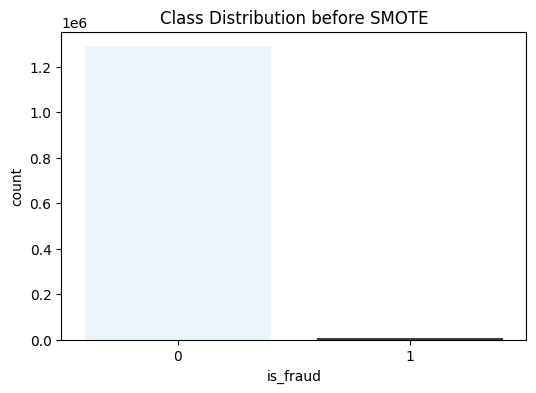

In [12]:
plt.figure(figsize=(6,4))
sns.countplot(x=y, palette=["#e8f5ff", "#463d36"])
plt.title("Class Distribution before SMOTE")
plt.show()


### **Using SMOTE to balance our dataset**

In [13]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
print(f"Resampled shape: {X_resampled.shape}")

Resampled shape: (2578338, 9)


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_29452\321093759.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_resampled, palette=["#a6ff85", "#F44040"])


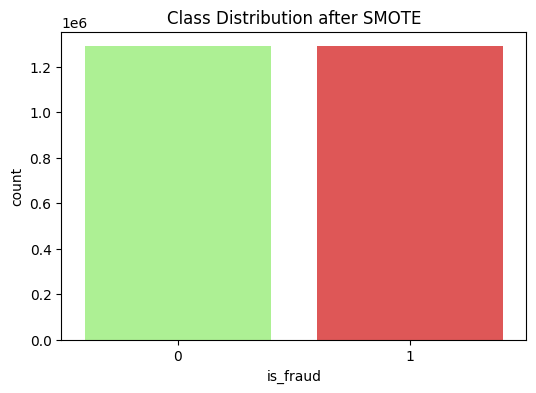

In [14]:
plt.figure(figsize=(6,4))
sns.countplot(x=y_resampled, palette=["#a6ff85", "#F44040"])
plt.title("Class Distribution after SMOTE")
plt.show()

### **Train and Test Split**

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled,
    test_size=0.2,
    random_state=42,
    stratify=y_resampled
)

X_train.shape, X_test.shape , y_train.shape, y_test.shape

((2062670, 9), (515668, 9), (2062670,), (515668,))

### **Training LightGBM Model**

In [17]:
# gbdt -> Gradient Boosting Decision Tree where tree are built to sequentially to reduce residual errors
# auc -> As it is good for imbalanced dataset considers sensitivity and specificity 
lgb_model = lgb.LGBMClassifier(
    boosting_type='gbdt',
    objective='binary',
    metric='auc',
    is_unbalance=True,
    learning_rate=0.05,
    num_leaves=31,
    n_estimators=200,
    random_state=42
)

lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='auc',
    callbacks=[
        lgb.early_stopping(20),
        lgb.log_evaluation(10)
    ],
    categorical_feature=categorical_features
)


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 1031335, number of negative: 1031335
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072799 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 2062670, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 20 rounds
[10]	valid_0's auc: 0.978052
[20]	valid_0's auc: 0.98353
[30]	valid_0's auc: 0.98771
[40]	valid_0's auc: 0.991043
[50]	valid_0's auc: 0.992603
[60]	valid_0's auc: 0.993221
[70]	valid_0's auc: 0.994345

LGBMClassifier(is_unbalance=True, learning_rate=0.05, metric='auc',
               n_estimators=200, objective='binary', random_state=42)

### **Model Evaluation**

In [18]:
y_pred = lgb_model.predict(X_test)
y_proba = lgb_model.predict_proba(X_test)[:, 1]

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba):.4f}")



Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98    257834
           1       0.99      0.98      0.98    257834

    accuracy                           0.98    515668
   macro avg       0.98      0.98      0.98    515668
weighted avg       0.98      0.98      0.98    515668

ROC-AUC Score: 0.9981


### **Important Features**

<Figure size 1000x600 with 0 Axes>

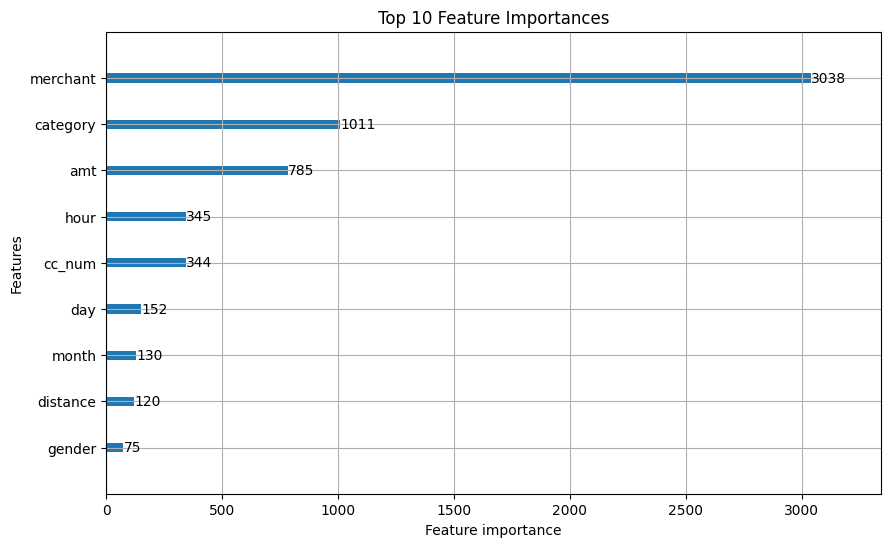

In [19]:
plt.figure(figsize=(10,6))
lgb.plot_importance(
    lgb_model,
    max_num_features=10,
    importance_type='split',
    figsize=(10,6)
)
plt.title("Top 10 Feature Importances")
plt.show()

### **ROC Curve**

In [20]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

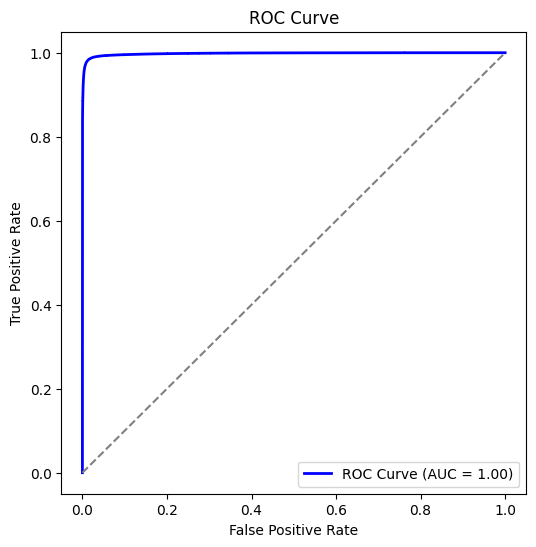

In [21]:

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

### **Saving Model**

In [22]:
joblib.dump(lgb_model, 'fraud_detector.jb')
joblib.dump(encoders, 'label_enc.jb')

['label_enc.jb']